In [1]:
!pip install --upgrade -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 73.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.0 MB/s eta 0:00:00:00:01


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
!pip install --upgrade pyarrow

In [4]:
# Load data
from datasets import load_dataset, DatasetDict

data = load_dataset('csv', data_files='/kaggle/input/contradictory-my-dear-watson/train.csv', split='train')
data

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
    num_rows: 12120
})

# Exploring Dataset

In [5]:
df = data.to_pandas()
df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [6]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

df.head(5).apply(lambda x : display_pair_of_sentence(x), axis=1)

df.shape

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

(12120, 6)

In [7]:
df[['premise', 'hypothesis', 'lang_abv', 'language']].describe()

,premise,hypothesis,lang_abv,language
count,12120,12120,12120,12120
unique,8209,12119,15,15
top,really oh i thought it was great yeah,I am not sure.,en,English
freq,3,2,6870,6870


In [8]:
df[['lang_abv', 'language']].value_counts()

lang_abv  language  
en        English       6870
zh        Chinese        411
ar        Arabic         401
fr        French         390
sw        Swahili        385
ur        Urdu           381
vi        Vietnamese     379
ru        Russian        376
hi        Hindi          374
el        Greek          372
th        Thai           371
es        Spanish        366
de        German         351
tr        Turkish        351
bg        Bulgarian      342
Name: count, dtype: int64

In [9]:
df.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

Text(0.5, 1.0, 'Distribution of labels in the training set')

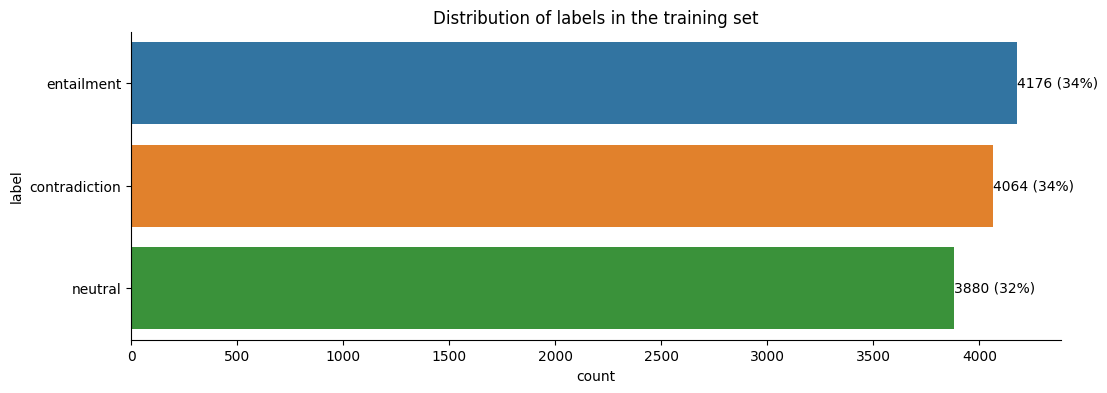

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df, 
                   y="label",
                   order = df['label'].value_counts().index)

abs_values = df['label'].value_counts(ascending=False)
rel_values = df['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Text(0.5, 1.0, 'Distribution of languages in the training set')

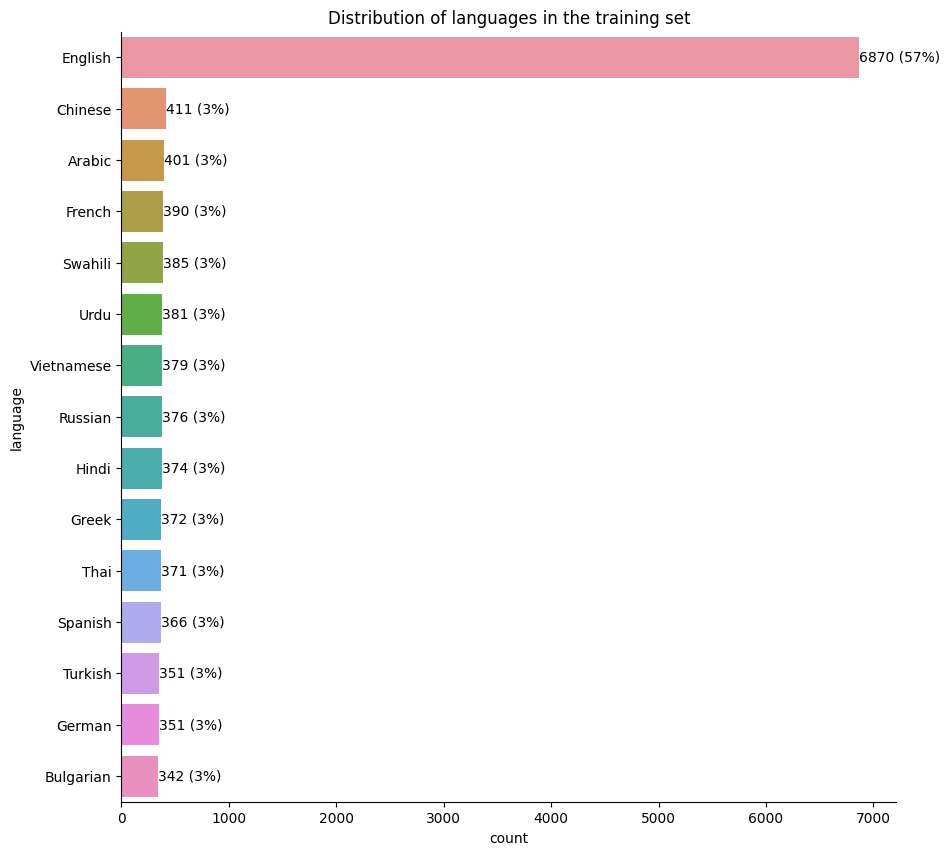

In [11]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df, 
                   y="language",
                   order = df['language'].value_counts().index)

abs_values = df['language'].value_counts(ascending=False)
rel_values = df['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [12]:
# Train, Validation data spliting
data_split = data.train_test_split(0.3)

data_dict = DatasetDict({
    'train': data_split['train'],
    'val': data_split['test'],
    'test':load_dataset('csv', data_files='/kaggle/input/contradictory-my-dear-watson/test.csv', split='train')
})

data_dict

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 8484
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 3636
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [13]:
from datasets import Dataset, DatasetDict
import pandas as pd

# 영어 데이터만 필터링
english_train = [sample for sample in data_dict['train'] if sample['lang_abv'] == 'en']
english_val = [sample for sample in data_dict['val'] if sample['lang_abv'] == 'en']
english_test = [sample for sample in data_dict['test'] if sample['lang_abv'] == 'en']

# 다국어 데이터만 필터링 (영어 제외)
multilingual_train = [sample for sample in data_dict['train'] if sample['lang_abv'] != 'en']
multilingual_val = [sample for sample in data_dict['val'] if sample['lang_abv'] != 'en']
multilingual_test = [sample for sample in data_dict['test'] if sample['lang_abv'] != 'en']

# 각 필터링된 데이터로 Dataset 객체 생성
english_data_dict = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(english_train)),
    'val': Dataset.from_pandas(pd.DataFrame(english_val)),
    'test': Dataset.from_pandas(pd.DataFrame(english_test))
})

multilingual_data_dict = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(multilingual_train)),
    'val': Dataset.from_pandas(pd.DataFrame(multilingual_val)),
    'test': Dataset.from_pandas(pd.DataFrame(multilingual_test))
})

# 결과 확인
print("English DataDict:")
print(english_data_dict)

print("\nMultilingual DataDict:")
print(multilingual_data_dict)


English DataDict:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 4833
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2037
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 2945
    })
})

Multilingual DataDict:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 3651
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 1599
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 2250
    })
})


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

# 영어 데이터에 맞는 모델
english_checkpoint = "sileod/deberta-v3-base-tasksource-nli"
english_tokenizer = AutoTokenizer.from_pretrained(english_checkpoint, truncation=True)
english_model = AutoModelForSequenceClassification.from_pretrained(english_checkpoint, num_labels=3)

# 다국어 데이터에 맞는 모델
multilingual_checkpoint = 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'
multilingual_tokenizer = AutoTokenizer.from_pretrained(multilingual_checkpoint, truncation=True)
multilingual_model = AutoModelForSequenceClassification.from_pretrained(multilingual_checkpoint, num_labels=3)

# 데이터 콜렉터 설정 (두 모델에서 사용할 수 있도록)
data_collator = DataCollatorWithPadding(tokenizer=multilingual_tokenizer)  # 영어 모델에 맞춘 tokenizer 사용

# 결과 출력 (영어 모델과 다국어 모델을 분리하여 출력)
print("English model:")
print(english_model)

print("\nMultilingual model:")
print(multilingual_model)

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

English model:
DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

# Preprocessing

In [15]:
def preprocess_data(batch, tokenizer):
    batch['text'] = [x1 + f' {tokenizer.sep_token} ' + x2 for x1, x2 in zip(batch['premise'], batch['hypothesis'])]
    return tokenizer(batch['text'])

# 영어 데이터에 대해서는 english_tokenizer 사용
english_data_dict = english_data_dict.map(lambda batch: preprocess_data(batch, english_tokenizer), batched=True)

# 다국어 데이터에 대해서는 multilingual_tokenizer 사용
multilingual_data_dict = multilingual_data_dict.map(lambda batch: preprocess_data(batch, multilingual_tokenizer), batched=True)

# 결과 확인
print("English DataDict after preprocessing:")
print(english_data_dict)

print("\nMultilingual DataDict after preprocessing:")
print(multilingual_data_dict)

Map:   0%|          | 0/4833 [00:00<?, ? examples/s]

Map:   0%|          | 0/2037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2945 [00:00<?, ? examples/s]

Map:   0%|          | 0/3651 [00:00<?, ? examples/s]

Map:   0%|          | 0/1599 [00:00<?, ? examples/s]

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

English DataDict after preprocessing:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4833
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2037
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2945
    })
})

Multilingual DataDict after preprocessing:
DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3651
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'token_t

# Loading TrainerAPI

In [16]:
!pip install evaluate

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:0000:01


In [17]:
from evaluate import load
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

def compute_metrics(eval_pred):
    metric = load("accuracy")
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)


eng_train_args = TrainingArguments(
    output_dir='results',
    logging_dir='logs',
    report_to=[],
    
    evaluation_strategy='steps',
    eval_steps=125,
    logging_steps=125,
    save_steps=125,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=3,
)

mul_train_args = TrainingArguments(
    output_dir='results',
    logging_dir='logs',
    report_to=[],
    
    evaluation_strategy='steps',
    eval_steps=125,
    logging_steps=125,
    save_steps=125,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=3,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
multilingual_trainer = Trainer(
    model=multilingual_model,  # 다국어 모델
    args=mul_train_args,
    train_dataset=multilingual_data_dict['train'],
    eval_dataset=multilingual_data_dict['val'],
    tokenizer=multilingual_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)]
)

multilingual_trainer.train()

<ipython-input-18-b41e3e5af86b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  multilingual_trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
125,0.377100,0.362278,0.873046
250,0.162300,0.529229,0.867417
375,0.082100,0.746134,0.871795
500,0.057800,0.924751,0.871795


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=500, training_loss=0.1698105869293213, metrics={'train_runtime': 434.5048, 'train_samples_per_second': 42.013, 'train_steps_per_second': 1.323, 'total_flos': 916263686304720.0, 'train_loss': 0.1698105869293213, 'epoch': 4.3478260869565215})

In [19]:
import torch

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [20]:
english_trainer = Trainer(
    model=english_model,  # 영어 모델
    args=eng_train_args,
    train_dataset=english_data_dict['train'],
    eval_dataset=english_data_dict['val'],
    tokenizer=english_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)]
)

english_trainer.train()

<ipython-input-20-29e727ca2a33>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  english_trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
125,0.271500,0.213626,0.922435
250,0.125100,0.280393,0.920962
375,0.062900,0.376708,0.918999
500,0.043600,0.459480,0.915562


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=500, training_loss=0.12576688957214355, metrics={'train_runtime': 338.4292, 'train_samples_per_second': 71.403, 'train_steps_per_second': 2.246, 'total_flos': 723562541217360.0, 'train_loss': 0.12576688957214355, 'epoch': 3.2894736842105265})

# Prediction

In [21]:
english_preds = english_trainer.predict(english_data_dict['test'])
multilingual_preds = multilingual_trainer.predict(multilingual_data_dict['test'])

In [22]:
print(english_preds)
print('-')
print(multilingual_preds)

PredictionOutput(predictions=array([[-1.453264 ,  1.541374 ,  0.3985035],
       [-1.3598436,  4.0540385, -1.9574851],
       [-1.8450125,  3.9157522, -1.2095591],
       ...,
       [-2.768429 , -0.222586 ,  3.288608 ],
       [ 3.4949217, -2.0623028, -2.6600292],
       [-2.0864718, -2.0219655,  4.9693236]], dtype=float32), label_ids=None, metrics={'test_runtime': 16.4275, 'test_samples_per_second': 179.272, 'test_steps_per_second': 5.661})
-
PredictionOutput(predictions=array([[-1.6142203 , -2.6283422 ,  4.5588665 ],
       [-2.0124292 ,  4.5248795 , -1.6961851 ],
       [ 3.905091  , -0.10783638, -3.6036394 ],
       ...,
       [ 3.5287426 , -0.64641476, -2.8787982 ],
       [ 2.3123658 ,  0.03557291, -2.3815017 ],
       [ 2.495266  , -0.41733572, -2.1781578 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 17.5825, 'test_samples_per_second': 127.968, 'test_steps_per_second': 4.038})


In [23]:
english_pred_labels = np.argmax(english_preds.predictions, axis=1)
multilingual_pred_labels = np.argmax(multilingual_preds.predictions, axis=1)

combined_pred_labels = np.concatenate([english_pred_labels, multilingual_pred_labels])

combined_ids = np.concatenate([english_data_dict['test']['id'], multilingual_data_dict['test']['id']])

submission_df = pd.DataFrame({
    'id': combined_ids,
    'prediction': combined_pred_labels
})

submission_df.to_csv('submission.csv', header=True, index=False)